# Проект 4. Исследование сервиса аренды самокатов GoFast

**Задача исследования** - проверить гипотезы:

1. Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.
2. Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров (расстояние, оптимальное с точки зрения износа самоката)
3. Средняя помесячная выручка от пользователей с подпиской по месяцам выше, чем средняя выручка от пользователей без подписки.

**Описание данных**

В основных данных есть информация о пользователях, их поездках и подписках.

1. Пользователи — users_go
- `user_id`	уникальный идентификатор пользователя
- `name` имя пользователя
- `age`	возраст
- `city` город
- `subscription_type` тип подписки (free, ultra)

2. Поездки — rides_go
- `user_id`	уникальный идентификатор пользователя
- `distance` расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` дата совершения поездки

3. Подписки — subscriptions_go
- `subscription_type` тип подписки
- `minute_price` стоимость одной минуты поездки по данной подписке
- `start_ride_price` стоимость начала поездки
- `subscription_fee` стоимость ежемесячного платежа

Существует 2 варианта пользования сервисом:
- без подписки:      
  - абонентская плата отсутствует;
  - стоимость одной минуты поездки — 8 рублей;
  - стоимость старта (начала поездки) — 50 рублей;
    
- с подпиской Ultra:      
   - абонентская плата — 199 рублей в месяц;
   - стоимость одной минуты поездки — 6 рублей;
   - стоимость старта — бесплатно.

**Ход исследования**

1. Проведем обзор данных - составим первое представление о предоставленных данных, оценим их объем и качество.
2. Выполним предобработку данных - проверим данные на возможные ошибки (аномалии, пропуски). Исправим данные.
3. Исследуем данные.
4. Проверим гипотезы. 

## 1. Обзор данных

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
sns.set_theme()

Выгрузим предоставленные данные и сохраним их в переменных:   
в *df_users* сохраним данные о пользователях;   
в *df_rides* - данные о поездках;   
в *df_subscrip* - данные о подписках.  

Первоначально выгрузим данные о пользователях:

In [2]:
df_users = pd.read_csv('/datasets/users_go.csv')
df_users.head(3)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra


In [3]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Получили верхние 3 строки датафрейма и общую информацию о файле через метод `info`. 
Названия столбцов соответствуют стилю. Данные распределены корректно по столбцам. В таблице 1565 строк и 5 столбцов. Пропущенные значения отсутствуют. Типы данных *int64* и *object*, типы данных соответствуют их содержанию.

Следующим шагом загрузим данные о поездках.

In [4]:
df_rides = pd.read_csv('/datasets/rides_go.csv')
df_rides.sample(3)

,user_id,distance,duration,date
10653,1003,2748.808387,15.680448,2021-08-10
1628,175,4738.383372,26.794611,2021-09-03
8639,860,3615.579841,19.558424,2021-01-02


In [5]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Просмотрели 3 произвольно выгруженных строки полученного датафрейма. Названия столбцов соответствуют стилю. Данные корректно распределены по столбцам. В датафрейме 18068 строк и 4 столбца. Пропущенные значения отсутствуют. Типы данных *float64*, *int64* и *object*. Тип данных в столбце *date* не соответствует содержанию. Переведем на следующем этапе в тип *datetime*.

Загрузим данные о подписках.

In [6]:
df_subscrip = pd.read_csv('/datasets/subscriptions_go.csv')
df_subscrip

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
df_subscrip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Данные корректно распределены по столбцам. Названия столбцов соответствует стилю. В датафрейме 2 строки и 4 столбца. Пропущенные значения отсутствуют. Типы данных *int64* и *object*, соответствуют содержанию.

**Вывод**

Для проведения анализа данные предоставлены в 3-х файлах, названия столбцов в каждом соответствуют стилю, отсутствуют пропущенные значения:

1. Данные о пользователях:   1565 строк и 5 столбцов. Типы данных int64 и object, типы данных соответствуют их содержанию.
2. Данные о поездках: 18068 строк и 4 столбца. Типы данных float64, int64 и object. Тип данных в столбце date не соответствует содержанию. Переведем  в тип datetime на следующем этапе.
3. Данные о подписках: в датафрейме 2 строки и 4 столбца. Типы данных int64 и object, соответствуют содержанию.

На следующем этапе более подробно изучим все столбцы, проверим на аномалии, дубликаты и исправим выявленные несоответствия. Данные *df_subscrip* не будем проверять, т.к. мы их полностью видели, там указана информация о типах подписки, все столбцы заполнены нужными значениями. 

## 2. Предобработка данных

### 2.1. Первым шагом исправим формат даты в данных *df_rides*.

In [8]:
df_rides['date'] = pd.to_datetime(df_rides['date'], format='%Y-%m-%d')
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Проверили изменения - тип данных в столбце *date* изменен на datetime64. 

### 2.2. Добавим новый столбец *date_month* с номером месяца.  

In [9]:
df_rides['date_month'] = df_rides['date'].dt.month
df_rides

,user_id,distance,duration,date,date_month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11


Новый столбец *date_month* добавлен. 

Проверим минимальную и максимальную даты в столбце *date*

In [10]:
df_rides['date'].min()

Timestamp('2021-01-01 00:00:00')

In [11]:
df_rides['date'].max()

Timestamp('2021-12-30 00:00:00')

Мы анализируем Данные за 2021 год.

### 2.3. Проверим данные на дубликаты

На 1-м этапе при общем знакомстве с данными мы выявили отсутствие пропусков. Нужно проверить дубликаты и аномалии в данных. 
Сначала посмотрим наличие неявных дубликатов.   

В данных *df_users* нас интересуют столбцы: 
- name
- city
- subscription_type   

Проверим уникальные значения в этих столбцах методом `unique()`

In [12]:
df_users['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

In [13]:
df_users['name'].nunique()

194

в столбце *name* значения уникальные, всего 194 уникальных имени, неявные дубликаты отсутствуют

In [14]:
df_users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [15]:
df_users['city'].nunique()

8

В столбце *city* значения уникальные, неявные дубликаты отсутствуют. В наших данных представлено 8 городов.

In [16]:
df_users['subscription_type'].unique()  

array(['ultra', 'free'], dtype=object)

В столбце *subscription_type* отражен тип подписки в 2-х вариантах, как и должно быть.

Теперь убедимся, что в столбце *age* данных *df_users* отсутствуют аномальные значения, тоже используем метод `unique()`.

In [17]:
df_users['age'].unique()

array([22, 31, 20, 26, 28, 25, 23, 21, 18, 27, 24, 29, 32, 14, 19, 30, 17,
       12, 35, 33, 13, 15, 37, 16, 34, 38, 36, 39, 43])

In [18]:
df_users['age'].nunique()

29

Данные о возрасте указаны без аномалий, нереалистичные значения отсутствуют. В данных представлено 29 возрастов.

Теперь проверим *df_users* на явные дубликаты. Посчитаем их количество через метод `duplicated().sum()`

In [19]:
df_users.duplicated().sum()

31

У нас есть 31 дублированная запись строк, избавимся от этих дубликатов и сразу проведем повторную проверку.

In [20]:
df_users = df_users.drop_duplicates()

In [21]:
df_users.duplicated().sum()

0

Мы избавились от дубликатов в данных *df_users*.   Проверим наличие дубликатов в данных *df_rides*

In [22]:
df_rides.duplicated().sum()

0

В данных `df_rides` дубликаты отсутствуют. 

Посмотрим на финальный размер наших данных *df_users*

In [23]:
df_users.shape

(1534, 5)

**Выводы**

На этапе предобработки мы выполнили следующие изменения в данных *df_users*:
- привели формат даты в соответствие типу даты Pandas;
- удалили дубликаты.

В данных *df_users* стало 1534 строки. Данные *df_rides* и *df_subscrip* остались без изменений.

В наших данных отсутствуют пропуски, аномальные значения, неявные дубликаты. На следующем этапе проанализируем имеющиеся у нас данные.

## 3. Исследовательский анализ данных

На этом этапе более подробно изучим имеющиеся у нас данные:
- частоту встречаемости городов;
- как соотносятся пользователи с подпиской и без подписки;
- возраст пользователей;
- расстояние, которое пользователь преодолел за одну поездку;
- продолжительность поездок.


### 3.1. Частота встречаемости городов

На предыдущем этапе мы узнали, что в наших данных 8 городов. Посмотрим, с какой частотой эти города представлены в выгрузке. Посчитаем количество присутствия городов в выгрузке и долю каждого города в общем объеме данных:

In [24]:
city = df_users.city.value_counts().reset_index()

In [25]:
city['share'] = round(city['city'] / city['city'].sum()*100, 2)
city

,index,city,share
0,Пятигорск,219,14.28
1,Екатеринбург,204,13.30
2,Ростов-на-Дону,198,12.91
3,Краснодар,193,12.58
4,Сочи,189,12.32
5,Омск,183,11.93
6,Тюмень,180,11.73
7,Москва,168,10.95


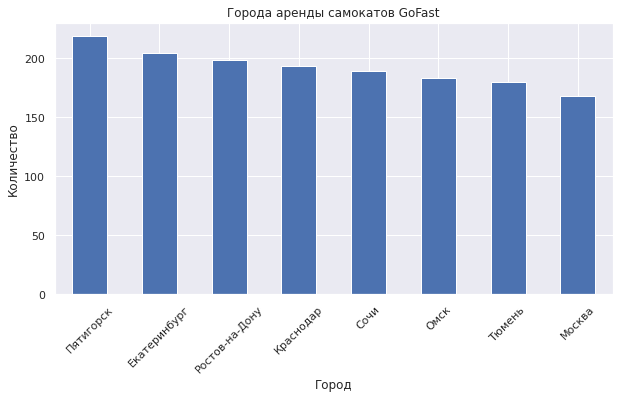

In [26]:
df_users.city.value_counts().plot(kind='bar', figsize=(10, 5), rot=45)
plt.title('Города аренды самокатов GoFast')
plt.xlabel('Город')
plt.ylabel('Количество')
plt.show()

Максимально представлен город Пятигорск 219 шт. (14,28%), минимум пользователей сервиса в Москве - 168 шт. (10,95%). В целом, все города распределены достаточно равномерно от 10,95% до 14,28%.

### 3.2. Соотношение пользователей с подпиской и без подписки

Сервис аренды самокатов предоставляет 2 типа оплаты: 
- с подпиской (*ultra*);
- без подписки (*free*). 

Посмотрим, какой тип оплаты предпочитают наши users.

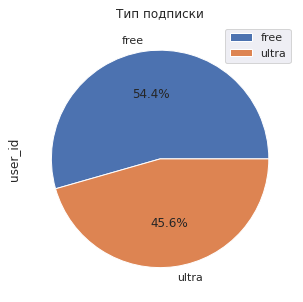

In [27]:
df_users.groupby('subscription_type')['user_id'].agg('count')\
        .plot(kind='pie', autopct='%1.1f%%', 
              title='Тип подписки', legend=True, figsize=(5,5))

plt.show()

54,4% пользователей предпочитают оплату без подписки, пользователей с подпиской примерно на 9% меньше - 45,6%

### 3.3. Возраст пользователей

На этапе предобработки мы насчитали 29 возрастов у пользователей. Теперь посмотрим частоту, с которой представлен возраст пользователей в общем объеме данных.

Описание возраста: 
 count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Возраст ТОП-3 пользователей: 
 25    145
24    132
26    131
Name: age, dtype: int64


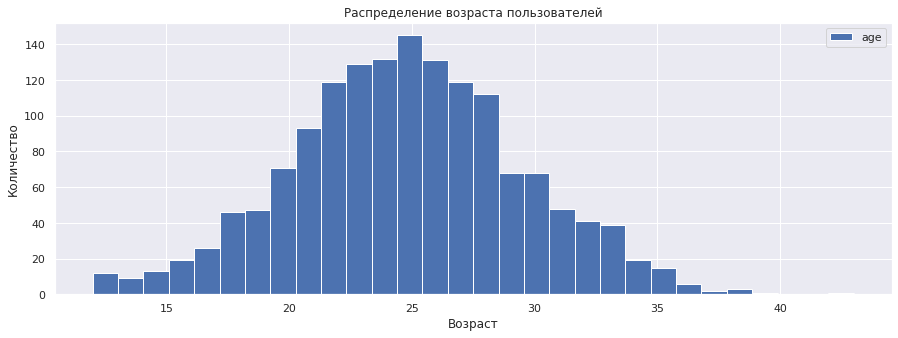

In [28]:
print('Описание возраста: \n', df_users.age.describe())
print()
print('Возраст ТОП-3 пользователей: \n', df_users.age.value_counts().head(3))
df_users.plot(y='age', kind='hist', bins=30, figsize=(15, 5))
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Средний возраст выборки 24,9 близок к медианному значению - 25, значит, в нашей выборке отсутствуют выбросы. Сервисом пользуются люди в возрасте от 12 до 43 лет (смущает возраст пользователей младше 18, сервис предоставляется несовершеннолетним). Самые активные пользователи ТОП-3 в возрасте 25, 24 и 26 лет. Самая активная возрастная группа  22-28 летние.

### 3.4. Расстояние, которое пользователь преодолел за одну поездку

Города, возраст и тип подписки мы изучили по данным *df_users*. Теперь обратимся ко второй таблице *df_rides* и изучим расстояние, которое преодолевают пользователи сервисом.

Описание параметра "Расстояние": 
 count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64



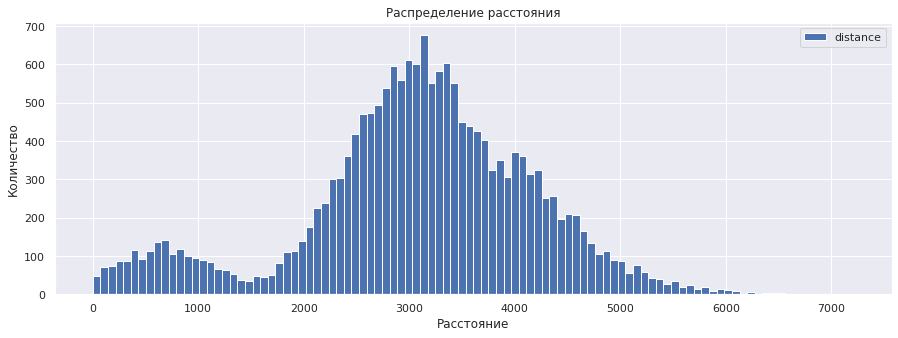

In [29]:
print('Описание параметра "Расстояние": \n', df_rides.distance.describe())
print()
df_rides.plot(y='distance', kind='hist', bins=100, figsize=(15, 5))
plt.title('Распределение расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.show()

Видим 2 пика. 1-й пик на уровне расстояния 500-700 м, и самый высокий пик на уровне 2700-3500 м. Эти расстояния можно определить как самое популярное ближнее расстояние поездок (500-700м) и самое популярное дальнее расстояние поездок (2700-3500м).
Минимальное расстояние для поездок - 0,85м, максимальное расстояние поездки 7211 м.

Посмотрим на среднее расстояние, которое проезжает каждый пользователь. Для этого сгруппируем нашу выгрузку по *user_id* и расстоянию.

In [30]:
df_rides.groupby('user_id')['distance'].agg(['count', 'mean']).head()

,count,mean
user_id,,
1,12,2839.181839
2,11,3087.641692
3,12,3075.633155
4,14,3202.656423
5,11,3232.449968


Получили таблицу, по которой, помимо среднего расстояния, сразу можем увидеть, с какой частотой пользователи арендовали самокаты.

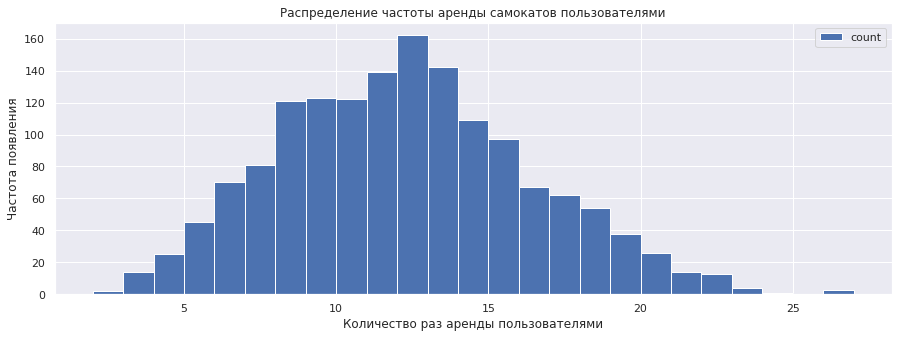

In [31]:
df_rides.groupby('user_id')['distance'].agg(['count', 'mean'])\
.plot(y='count', kind='hist', bins=25, figsize=(15, 5))
plt.title('Распределение частоты аренды самокатов пользователями')
plt.xlabel('Количество раз аренды пользователями')
plt.ylabel('Частота появления')
plt.show()

Мы видим, чаще всего пользователи совершили по 13 поездок в отчетном периоде. Наиболее популярное количество обращений к сервису аренды от 8 до 16 за анализируемый период. Теперь посмотрим среднее расстояние по каждому пользователю.

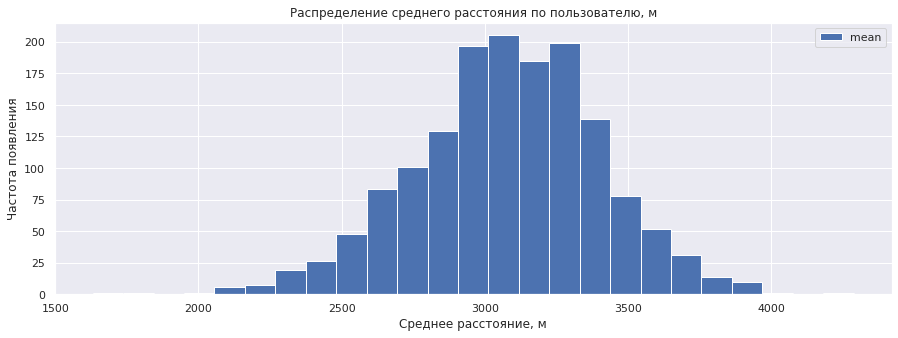

In [32]:
df_rides.groupby('user_id')['distance'].agg(['count', 'mean'])\
.plot(y='mean', kind='hist', bins=25, figsize=(15, 5))
plt.title('Распределение среднего расстояния по пользователю, м')
plt.xlabel('Среднее расстояние, м')
plt.ylabel('Частота появления')
plt.show()

По графику видим, большинство пользователей совершают поездки на среднее расстояние 2900-3300 м. Единицы пользователей в среднем ездили на расстояние чуть более 2000 м или около 4000 м.

### 3.5. Продолжительность поездок

Рассмотрим данные о длительности поездок.

Описание параметра "Продолжительность поездки": 
 count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64



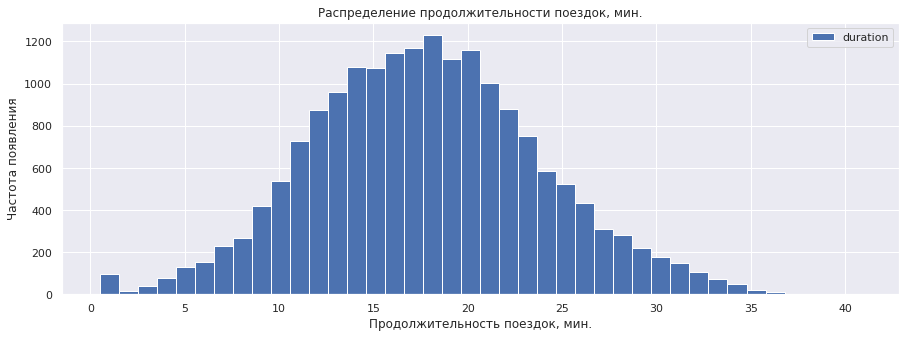

In [33]:
print('Описание параметра "Продолжительность поездки": \n', df_rides.duration.describe())
print()
df_rides.plot(y='duration', kind='hist', bins=40, figsize=(15, 5))
plt.title('Распределение продолжительности поездок, мин.')
plt.xlabel('Продолжительность поездок, мин.')
plt.ylabel('Частота появления')
plt.show()

Среднее значение 17,8 находится очень близко к медианному 17.68, значит, выбросы в наших данных отсутствуют. Минимальное время поездки 0,5 минуты, а максимальное почти 41 минута. Большинство поездок длительностью от 14 до 20 минут (пик на графике). Отдельно на графике выделяется столбец с длительностью поездок до 1 минуты.

Посмотрим на среднее время, которое затрачивают на поездки пользователи. Для этого сгруппируем нашу выгрузку по *user_id* и времени.

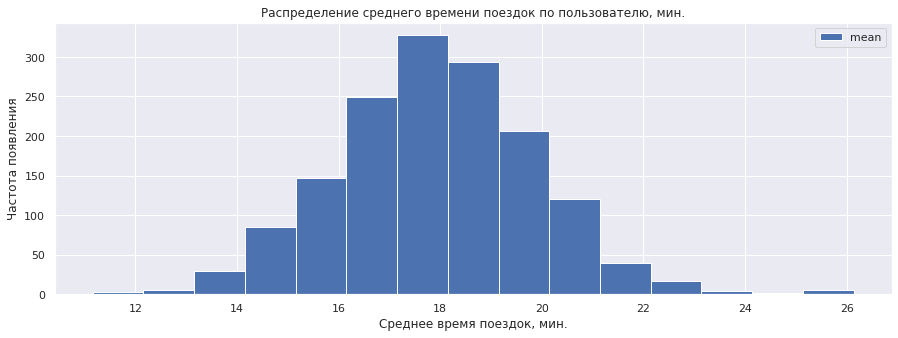

In [34]:
df_rides.groupby('user_id')['duration'].agg(['count', 'mean'])\
.plot(y='mean', kind='hist', bins=15, figsize=(15, 5), title='Среднее время поездок по пользователю')
plt.title('Распределение среднего времени поездок по пользователю, мин.')
plt.xlabel('Среднее время поездок, мин.')
plt.ylabel('Частота появления')
plt.show()

Больше всего в выборке пользователей, у которых среднее время на поездки составляет 18 минут. Большинство пользователей в среднем затрачивают на поездки по 17-20 минут. Другая средняя длительность поездок встречается реже.

**Выводы**

1. В наших данных представлено 8 городов. Максимально представлен город Пятигорск 14,28%, минимум пользователей сервиса в Москве 10,95%. В целом, все города распределены достаточно равномерно от 10,95% до 14,28%;
2. 54,4% пользователей предпочитают оплату без подписки, пользователей с подпиской примерно на 9% меньше - 45,6%;
3. Сервисом пользуются люди в возрасте от 12 до 43 лет. Самые активные пользователи ТОП-3 в возрасте 25, 24 и 26 лет. Самая активная возрастная группа 22-28 летние.
4. Минимальное расстояние для поездок - 0,85м, максимальное расстояние поездки 7211 м. Самое популярное ближнее расстояние поездок (500-700м), а самое популярное дальнее расстояние поездок (2700-3500м). Большинство пользователей совершают поездки на среднее расстояние 2900-3300 м. 
5. Минимальное время поездки 0,5 минуты, а максимальное почти 41 минута. Большинство поездок длительностью от 14 до 20 минут. Большинство пользователей в среднем затрачивают на поездки по 17-20 минут.
6. Чаще всего пользователи совершили по 13 поездок. Наиболее популярное количество обращений к сервису аренды от 8 до 16 за анализируемый период. 

Теперь перейдем к проверке наших гипотез.



## 4. Проверка гипотез

### 4.1. Объединение данных

#### 4.1.1. Объединим имеющиеся данные в общий датафрейм. 
За основу возьмем датафрейм *df_rides*, добавим другие два датафрейма.

In [35]:
df = df_rides.merge(df_users, on='user_id')
df

,user_id,distance,duration,date,date_month,name,age,city,subscription_type
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra
...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free


In [36]:
df_total = df.merge(df_subscrip, on='subscription_type')
df_total.head()

,user_id,distance,duration,date,date_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [37]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   date_month         18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Мы объединили наши данные в общем датафрейме *df_total*, он состоит из 18068 строк и 12 столбов. Типы данных datetime64, float64, int64, object.

#### 4.1.2. На основании общего *df_total* создадим еще 2 датафрейма:
- *df_free*, сюда сделаем выборку данных по пользователям без подписки.
- *df_ultra*, сюда выберем данные по пользователям с подпиской.

In [38]:
df_free = df_total.query('subscription_type == "free"')
df_free.shape

(11568, 12)

In [39]:
df_ultra = df_total.query('subscription_type == "ultra"')
df_ultra.shape

(6500, 12)

Мы создали два новых датафрейма по типам оплаты: с подпиской и без подписки. Датафрейм без подписки содержит 11568 строк, Датафрейм с подпиской содержит 6500 строк. 
Теперь сравним между собой пользователей с каждым типом оплаты по расстоянию и времени поездок.

Сравним расстояние:

Описание параметра "Расстояние поездки пользователей без подписки": 
 count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

Описание параметра "Расстояние поездки пользователей с подпиской": 
 count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64



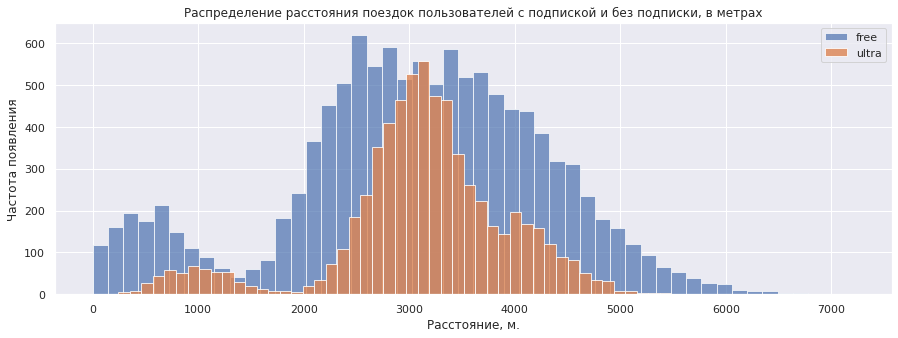

In [40]:
print('Описание параметра "Расстояние поездки пользователей без подписки": \n', df_free.distance.describe())
print()
print('Описание параметра "Расстояние поездки пользователей с подпиской": \n', df_ultra.distance.describe())
print()
ax = df_free.plot(
    kind='hist',
    y='distance',
    bins=50,
    figsize=(15, 5),
    alpha=0.7,
    label='free',
    title='Распределение расстояния поездок пользователей с подпиской и без подписки, в метрах')

df_ultra.plot(
    kind='hist',
    y='distance',
    bins=50,
    alpha=0.8,
    label='ultra',
    ax=ax,
    legend=True)

plt.xlabel('Расстояние, м.')
plt.ylabel('Частота появления')
plt.show()

Оба графика показывают нам два явных пика, поездки на ближние расстояния (до 1300 м) и на более дальние расстояния в интервале 2500-4000 м.
- Минимальное расстояние поездок: с подпиской 244м, без подписки 0,85м.
- Максимальное расстояние поездок: с подпиской 5700м, без подписки 7211м.    
Т.о., размах расстояния у клиентов без подписки больше, чем у клиентов с подпиской.

**Клиенты без подписки** чаще совершают поездки на расстояние до 1000 м, чем клиенты с подпиской.   
Большинство клиентов без подписки ездят на расстояние от 2200 до 4400м. Так же, клиенты без подписки чаще ездят на более длинные расстояния - до 7000 м.

**Клиенты с подпиской** чаще ездят на расстояние 2700-3500м и активно ездят на расстояние 4000-4300м. На ближние расстояния чаще ездят 700-1300м.

Теперь сравним время поездок между выборками:

Описание параметра "Длительность поездки пользователей без подписки": 
 count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

Описание параметра "Длительность поездки пользователей с подпиской": 
 count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64



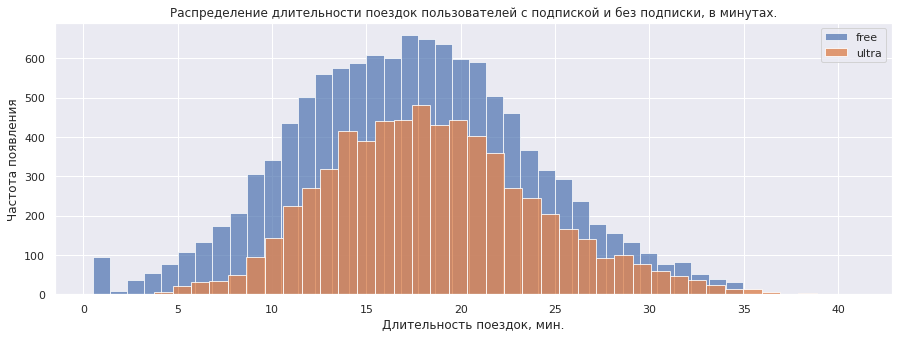

In [41]:
print('Описание параметра "Длительность поездки пользователей без подписки": \n', df_free.duration.describe())
print()
print('Описание параметра "Длительность поездки пользователей с подпиской": \n', df_ultra.duration.describe())
print()
ax = df_free.plot(
    kind='hist',
    y='duration',
    bins=38,
    figsize=(15, 5),
    alpha=0.7,
    label='free',
    title='Распределение длительности поездок пользователей с подпиской и без подписки, в минутах.')

df_ultra.plot(
    kind='hist',
    y='duration',
    bins=38,
    alpha=0.8,
    label='ultra',
    ax=ax,
    legend=True)

plt.xlabel('Длительность поездок, мин.')
plt.ylabel('Частота появления')
plt.show()

- Минимальное время поездок у клиентов без подписки 0.5 мин, а у клиентов с подпиской 3,76 мин.
- Максимальное время поездок у клиентов без подписки ~35мин, с подпиской ~41 мин.

С учетом расстояния поездок можно сделать вывод, что клиенты с подпиской ездят на более дальние расстояния, но тратят на эти поездки времени меньше, чем клиенты с подпиской. Значит, ездят с более высокой скоростью. А клиенты с подпиской ездят медленнее.

Распределение графиков по времени достаточно похоже у обеих групп пользователей. Большинство клиентов как с подпиской, так и без подписки тратят на поездки по 13-22 мин.
Клиентам без подписки свойственно совершать быстрые поездки - до 3х минут, клиенты с подпиской такие короткие поездки не совершают. 


### 4.2. Подсчёт выручки

Посчитаем ежемесячную выручку по пользователям сервиса аренды самокатов. Для этого сначала вычислим суммарное расстояние и суммарное время по каждому пользователю за месяц. Создадим сводную таблицу, сгруппируем ее по столбцу `user_id`.

Предварительно округлим время в столбце `duration` до большего значения в исходном датафрейме:

In [42]:
df_total['duration'] = np.ceil(df_total['duration']) 

In [43]:
df_agg = df_total.pivot_table(index=['user_id', 'date_month', 'subscription_type', \
                                     'minute_price', 'start_ride_price', 'subscription_fee'], \
            aggfunc={'name': len, 'distance': sum, 'duration': sum}).reset_index()
df_agg = df_agg.rename(columns={'name': 'trips_user'})
df_agg.head(10)

,user_id,date_month,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,trips_user
0,1,1,ultra,6,0,199,7027.511294,42.0,2
1,1,4,ultra,6,0,199,754.159807,7.0,1
2,1,8,ultra,6,0,199,6723.470560,46.0,2
3,1,10,ultra,6,0,199,5809.911100,32.0,2
4,1,11,ultra,6,0,199,7003.499363,56.0,3
5,1,12,ultra,6,0,199,6751.629942,28.0,2
6,2,3,ultra,6,0,199,10187.723006,63.0,3
7,2,4,ultra,6,0,199,6164.381824,40.0,2
8,2,6,ultra,6,0,199,3255.338202,14.0,1
9,2,7,ultra,6,0,199,6780.722964,48.0,2


In [44]:
df_agg.shape

(11331, 9)

В полученном датафрейме 11331 строка.

Проверим результат, выведем 3 строки датафрейма.

In [45]:
df_agg.head(3)

,user_id,date_month,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,trips_user
0,1,1,ultra,6,0,199,7027.511294,42.0,2
1,1,4,ultra,6,0,199,754.159807,7.0,1
2,1,8,ultra,6,0,199,6723.470560,46.0,2


Время округлено.

Теперь проведем расчет выручки по формуле:
((стоимость старта поездки ×  количество поездок) + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах) + стоимость подписки) и запишем значения в новый столбец `revenue_user`

In [46]:
df_agg['revenue_user'] = ((df_agg['start_ride_price']*df_agg['trips_user']) + \
                         (df_agg['minute_price']*df_agg['duration']) + df_agg['subscription_fee'])
df_agg.head(3)

,user_id,date_month,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,trips_user,revenue_user
0,1,1,ultra,6,0,199,7027.511294,42.0,2,451.0
1,1,4,ultra,6,0,199,754.159807,7.0,1,241.0
2,1,8,ultra,6,0,199,6723.470560,46.0,2,475.0


Столбец `revenue_user` добавлен, выручка посчитана за каждый месяц. 

Определим среднюю выручку за месяц, в зависимости от типа подписки:

In [47]:
df_agg.groupby('subscription_type')['revenue_user'].mean()

subscription_type
free     328.641365
ultra    362.792191
Name: revenue_user, dtype: float64

Средняя выручка выше у клиентов с подпиской (`ultra`).

### 4.3. Проверим гипотезы

Теперь приступим к проверке наших гипотез:
1. Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.
2. Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.
3. Средняя помесячная выручка от пользователей с подпиской по месяцам выше, чем средняя выручка от пользователей без подписки.

#### 4.3.1. Гипотеза 1

Нулевая гипотеза: `Пользователи с подпиской и без подписки тратят на поездки одинаковое время`.

Альтернативная гипотеза: `Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки`.

Для проверки гипотезы воспользуемся методом `scipy.stats.ttest_ind()`

Нам потребуются отдельные выборки по каждому типу оплаты: `df_ultra` и `df_free`.

In [48]:
duration_ultra = df_ultra['duration']

duration_free = df_free['duration']

alpha = 0.05
results = st.ttest_ind(duration_ultra, duration_free, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


На основании проведенного теста есть основания отвергнуть нулевую гипотезу. Есть основания говорить о том, что пользователи с подпиской тратят на поездки больше времени, чем пользователи без подписки.

#### 4.3.2. Гипотеза 2

Нулевая гипотеза: `Расстояние, которое проезжают пользователи с подпиской, равна значению, не превышающему 3130 м.`

Альтернативная гипотеза: `Расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров.`

Для проверки гипотезы воспользуемся методом `scipy.stats.ttest_1samp()`, проверку проведем на выборке `df_ultra`.


In [49]:
distance = df_ultra['distance']
limit_distance = 3130
alpha = 0.05
results = st.ttest_1samp(distance, limit_distance, alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


У нас нет оснований отвергать нулевую гипотезу. Наша альтернативная гипотеза о том, что пользователи с подпиской ездят на расстояние, превышающее 3130м, не подтверждена. Это значит, что среднее расстояние, которое проезжают пользователи с подпиской, не превышает 3130 м. 

#### 4.3.3. Гипотеза 3

Нулевая гипотеза: `Средняя помесячная выручка от пользователей с подпиской по месяцам равна средней выручке от пользователей без подписки.`

Альтернативная гипотеза: `Средняя помесячная выручка от пользователей с подпиской по месяцам выше, чем средняя выручка от пользователей без подписки.`

Для проверки гипотезы воспользуемся методом `scipy.stats.ttest_ind()`. Данные о выручке у нас содержатся в датафрейме `df_agg`, на его основе создадим два списка: с выручкой пользователей с подпиской и с выручкой пользователей без подписки.

In [50]:
revenue_ultra = df_agg.query('subscription_type == "ultra"')['revenue_user']

revenue_free = df_agg.query('subscription_type == "free"')['revenue_user']

alpha = 0.05
results = st.ttest_ind(revenue_ultra, revenue_free, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


На основании проведенного теста есть основание отвергнуть нулевую гипотезу. Есть основания считать, что от пользователей с подпиской средняя ежемесячная выручка выше, чем от пользователей без подписки.

**Выводы**  

Выдвинутые нами гипотезы подтвердились.
- Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.
- Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м.
- Средняя помесячная выручка от пользователей с подпиской по месяцам выше, чем средняя выручка от пользователей без подписки.

## 5. Итоги исследования

Мы провели исследование сервиса аренды самокатов GoFast.
Изначально перед нами стояла задача проверить 3 гипотезы:

1. Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.
2. Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.
3. Средняя помесячная выручка от пользователей с подпиской по месяцам выше, чем средняя выручка от пользователей без подписки.

Для исследования мы использовали данные 3х датафреймов:
- данные о пользователях (возраст, город, тип подписки)
- данные о поездках (даты поездок, расстояние, длительность поездки)
- данные о 2-х типах подписки (особенности тарификации каждой)

Нам предоставили выгрузки за 2021 год. Данные потребовали минимум корректировок, в них отсутствовали пропуски, аномальные значения, неявные дубликаты. Мы только скорректировали формат даты и удалили дубликаты.

В процессе исследования выявили такие особенности по нашим пользователям: 

- Представлено 8 городов. Максимально представлен город Пятигорск 14,28%, минимум пользователей сервиса в Москве 10,95%;
- 54,4% пользователей без подписки, с подпиской примерно на 9% меньше - 45,6%;
- Сервисом пользуются люди в возрасте от 12 до 43 лет. Самые активные пользователи ТОП-3 в возрасте 25, 24 и 26 лет. Самая активная возрастная группа 22-28 летние.
- Чаще всего пользователи совершили по 13 поездок. Наиболее популярное количество обращений к сервису аренды от 8 до 16 за анализируемый период. 
- Минимальное расстояние поездок у клиентов с подпиской 244м, без подписки - 0,85м. Максимальное расстояние поездок с подпиской 5700м, без подписки 7211м. Размах расстояния у клиентов без подписки больше, чем у клиентов с подпиской. Клиенты без подписки чаще совершают поездки на расстояние до 1000 м, чем клиенты с подпиской. Большинство клиентов без подписки ездят на расстояние от 2200 до 4400м, они же чаще ездят на более длинные расстояния - до 7000 м.  Клиенты с подпиской чаще ездят на расстояние 2700-3500м, **что может говорить в пользу нашей 2-й гипотезы: Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м.**. Результат статистического теста тоже подтверждает эту гипотезу. 
- Минимальное время поездок у клиентов без подписки 0.5 мин, а у клиентов с подпиской 3,76 мин. Максимальное время поездок у клиентов без подписки ~35мин, с подпиской ~41 мин. Большинство пользователей тратят на поездки по 13-22 мин. Клиентам без подписки свойственно совершать быстрые поездки - до 3х минут, клиенты с подпиской такие короткие поездки не совершают.

На основе анализа длительности поездок, с учетом анализа расстояния, можно сделать вывод, что клиенты с подпиской ездят на более дальние расстояния, но тратят на эти поездки времени меньше, чем клиенты с подпиской. Значит, они ездят с более высокой скоростью. А **клиенты с подпиской ездят медленнее и тратят на поездки больше времени. Это подтверждает нашу 1-ю гипотезу**. Результаты статистического теста тоже говорят в пользу этой гипотезы. 

По результатам проверки 3-й гипотезы есть все основания говорить о том, что **пользователи с подпиской помесячно приносят денег больше, чем пользователи без подписки**.

Резюмируем вышеизложенное:
- Клиенты с подпиской тратят на поездки больше времени;
- Ежемесячная выручка от клиентов с подпиской выше;
- Клиенты с подпиской ездят на расстояние, оптимальное с точки зрения износа самокатов  (не превышающее 3130 м).

Очевидно, компании GoFast выгодно увеличивать количество пользователей с подпиской.